In [2]:
import warnings
warnings.filterwarnings("ignore")

from routing_utils import from_sumo_to_igraph_network
from routing_algorithms import *
import matplotlib.pyplot as plt

from plot_utils import gdf_from_sumo_network, edges_to_gps_list, plot_paths, plot_bar_paths_cost

## Load the SUMO road network and convert it to an Igraph network

In [3]:
%%time

road_network_path = f"./road_networks/milan_big_road_network.net.xml"
sumo_road_network = sumolib.net.readNet(road_network_path)
gdf_net = gdf_from_sumo_network(sumo_road_network, crs="EPSG:4326", edge_list=None)

# Convert the sumo network into an Igraph network
G = from_sumo_to_igraph_network(sumo_road_network)

Wall time: 13 s


### Select and origin and destination edge

In [4]:
# select and origin and destination edge
o = "-80898294#1"
d = "86768854#0"

# select the attribute to consider
attribute = "traveltime"

## K-shortest paths

A naive solution to generate a set of k alternatives is to compute the  k-shortest paths between an origin and a destination. 

However, in practical scenarios, the k-shortest path solutions fail to provide significant path diversification, as the generated paths exhibit a 99% overlap showing only minor differences, such as cutting a corner or small detours.

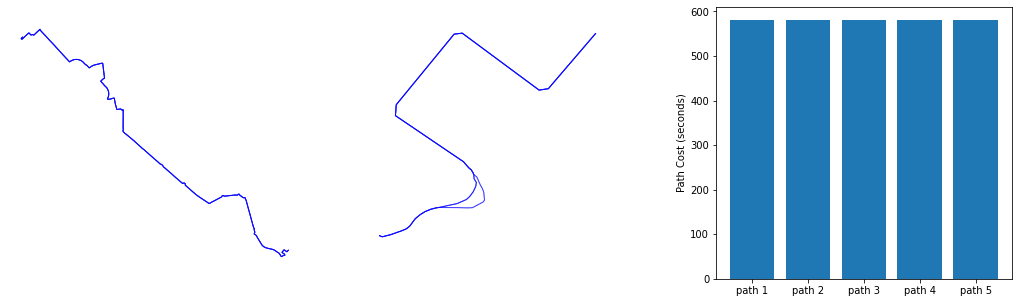

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5));

ks_paths = k_shortest_paths(G, sumo_road_network.getEdge(o), sumo_road_network.getEdge(d), 5, attribute)

# visualize the paths
plot_paths(sumo_road_network, gdf_net, ks_paths, ax=ax[0], plot_network=False)

# visualize a small detour
plot_paths(sumo_road_network, gdf_net, ks_paths, ax=ax[1], bbox=[[9.245, 9.248],[45.429, 45.4312]], plot_network=False)

# visualize the cost of each path
plot_bar_paths_cost(ks_paths, ax=ax[2], y_label="Path Cost (seconds)")

- The first plot shows the k alternatives (see how much they are overlapped);
- The second plot shows a small detour;
- The third plot shows the path cost of each alternative;

## K-disjoint 

A strict way to enforcing diversity between paths is defined by the problem of k-shortest disjoint paths, i.e., a set of k alternative paths with no common edges.

Solutions to this problem often result in routes that significantly deviate from the optimal path, leading to a notable increase in travel time and route length. Moreover, there is no guarantee that k disjoint paths exists between an origin destination pair.

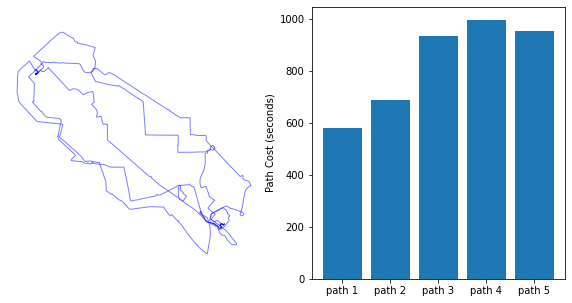

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5));


kd_paths = k_disjointed(G, o, d, 5, attribute)

# visualize the paths
plot_paths(sumo_road_network, gdf_net, kd_paths, ax=ax[0], plot_network=False)

# visualize the cost of each path
plot_bar_paths_cost(kd_paths, ax=ax[1], y_label="Path Cost (seconds)")

- The first plot shows the k alternatives;
- The second plot shows the path cost of each alternative.

## Graph Randomization

Graph Randomization (GR) generates k alternative paths from O to D by randomizing the weights of all edges in the road network before each fastest path computation.

The randomization is done by adding a value to each edge weight 𝑤(𝑒) from a normal distribution, given by the equation 𝑁(0, 𝑤(𝑒)2 · 𝛿2)


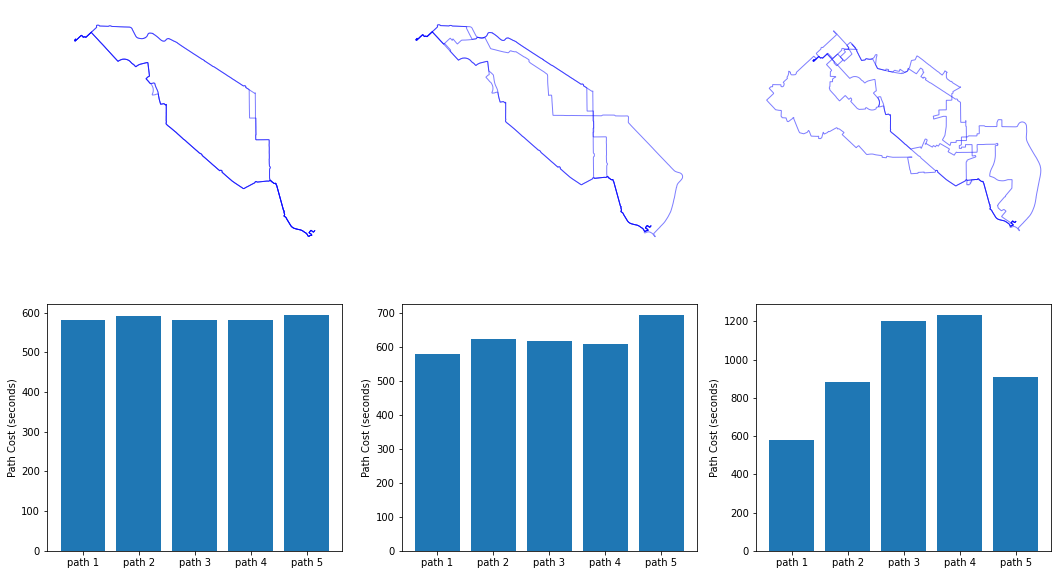

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10));

for ind, delta in enumerate([0.1, 0.2, 1]):
    gr_paths = graph_randomization(G, o, d, 5, delta, .01, attribute)
    plot_paths(sumo_road_network, gdf_net, gr_paths, ax=ax[0][ind], plot_network=False)
    plot_bar_paths_cost(gr_paths, ax=ax[1][ind], y_label="Path Cost (seconds)")

- Each plot in the first row shows the k alternatives for different values of delta (see how the geographical extent changes);
- Each plot in the first row shows the path cost of each alternative for different values of delta.

## Path Randomization

Path Randomization (PR) generates k alternative paths from O to D by randomizing only the weights of the edges that were part of the previously computed path.

Similar to GR, at each iteration it adds a value from a normal distribution to the edge weights following the equation 𝑁(0, 𝑤(𝑒)2 · 𝛿2)

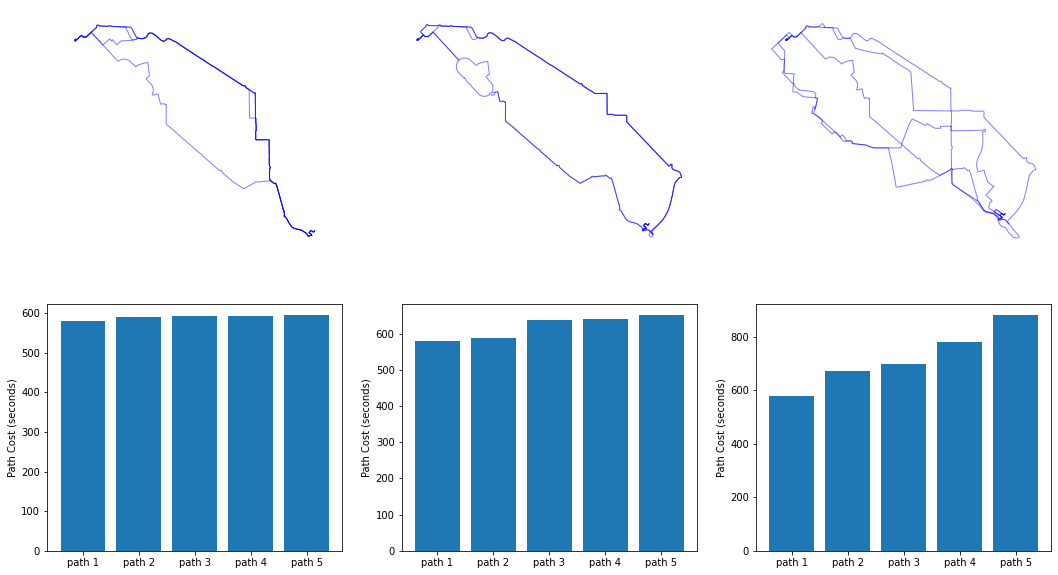

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10));

for ind, delta in enumerate([0.1, 0.2, 1]):
    pr_paths = path_randomization(G, o, d, 5, delta, .01, attribute)
    plot_paths(sumo_road_network, gdf_net, pr_paths, ax=ax[0][ind], plot_network=False)
    plot_bar_paths_cost(pr_paths, ax=ax[1][ind], y_label="Path Cost (seconds)")

- Each plot in the first row shows the k alternatives for different values of delta (see how the geographical extent changes);
- Each plot in the first row shows the path cost of each alternative for different values of delta.

## Path Penalization

Path Penalization (PP) generates k alternative routes from O to D by penalizing the weights of edges contributing to the fastest path.

In each iteration, PP computes the fastest path and increases the weights of the edges that contributed to it by a factor p as 𝑤 (𝑒) = 𝑤 (𝑒) · (1 + p). The penalization is cumulative: if an edge has already been penalized in a previous iteration, its weight will be further increased

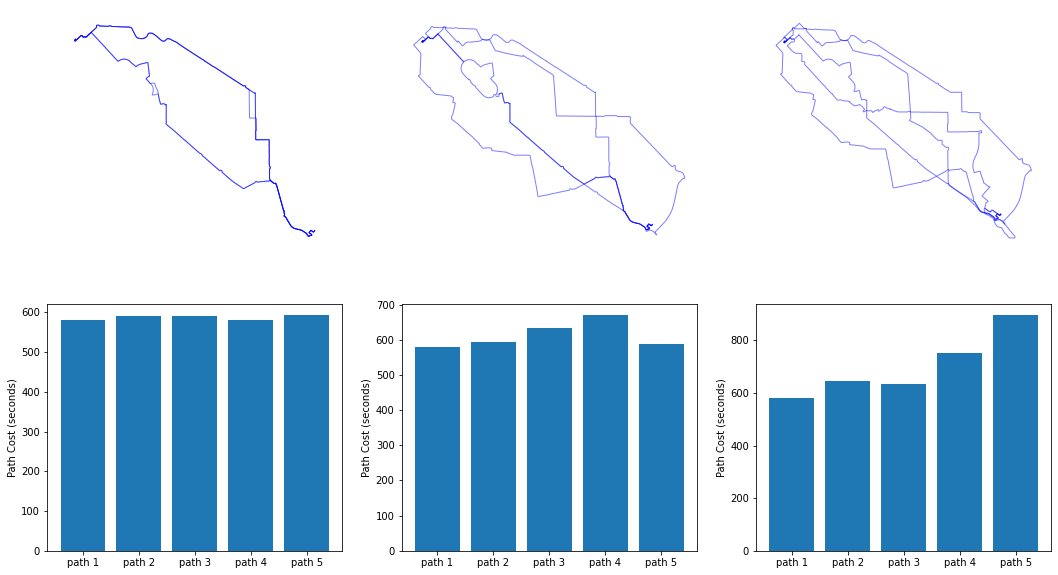

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10));

for ind, p in enumerate([0.01, 0.2, 1]):
    pp_paths = path_penalization(G, o, d, 5, p, attribute)
    plot_paths(sumo_road_network, gdf_net, pp_paths, ax=ax[0][ind], plot_network=False)
    plot_bar_paths_cost(pp_paths, ax=ax[1][ind], y_label="Path Cost (seconds)")

- Each plot in the first row shows the k alternatives for different values of p (see how the geographical extent changes);
- Each plot in the first row shows the path cost of each alternative for different values of p.

## Plateau

Plateau-based approaches build two shortest-path trees, one from the source and one from the destination:
Then identify their common branches, known as plateaus. 
The top-k plateaus are selected (on their lengths), and alternative paths are generated by appending the fastest paths from the source to the first edge of the plateau and from the last edge to the target.


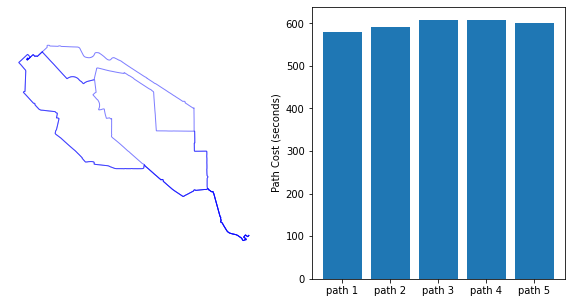

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5));

pla_paths = plateau_algorithm(G, o, d, 5, attribute, 3)

plot_paths(sumo_road_network, gdf_net, pla_paths, ax=ax[0], plot_network=False)

plot_bar_paths_cost(pla_paths, ax=ax[1], y_label="Path Cost (seconds)")

- The first plot shows the k alternatives;
- The second plot shows the path cost of each alternative.

## KMD

KMD is generates a 𝑘 routes with the highest dissimilarity among each other while still adhering to a user-defined cost threshold 𝜖. 

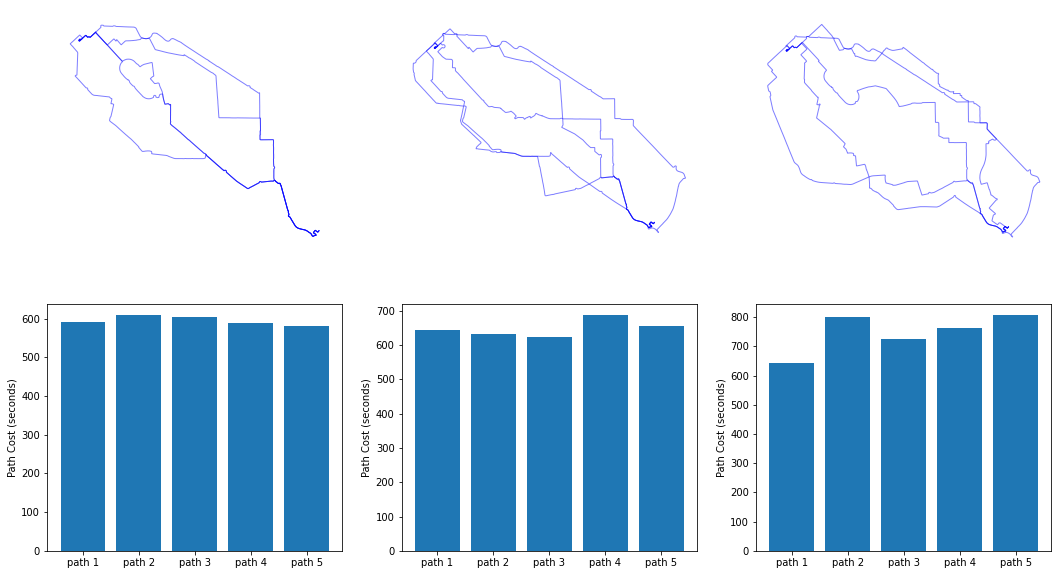

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10));

for ind, eps in enumerate([0.1, 0.3, 0.5]):
    kmd_paths = k_mdnsp(G, o, d, 5, eps, attribute)
    plot_paths(sumo_road_network, gdf_net, kmd_paths, ax=ax[0][ind], plot_network=False)
    plot_bar_paths_cost(kmd_paths, ax=ax[1][ind], y_label="Path Cost (seconds)")


- Each plot in the first row shows the k alternatives for different values of epsilon (see how the geographical extent changes);
- Each plot in the first row shows the path cost of each alternative for different values of epsilon.

